In [1]:
pip install langchain_community langchain faiss-cpu pymupdf Pillow langchain_openai langchain_core pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 6.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: openai
    Found existing installation: openai 1.42.0
    Uninstalling openai-1.42.0:
      Successfully uninstalled openai-1.42.0

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import dotenv
import os
from openai import OpenAI
import numpy as np
import faiss
import base64
import io
import fitz
from PIL import Image
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

In [2]:
# load enviorment variables
dotenv.load_dotenv('/Users/adityanarvekar/genai/.env', verbose=True)

True

In [70]:
class Reader_10K:
    def __init__(self, file_path):
        self.file_path = file_path
        self.client = OpenAI(
        api_key=os.environ["MAIB_KEY1"],  
        #api_key="<Put your API Key here and comment above line>",
        )
        self.llm = ChatOpenAI(
        api_key=os.environ["MAIB_KEY1"],  
        #api_key="<Put your API Key here and comment above line>",
        model ='gpt-4o'
        )

    # Function that reads the PDF file
    def load_documents(self):
        loader = PyPDFLoader(self.file_path)
        docs = loader.load()
        return docs

    # Function that breaks the PDF file into chunks
    def break_into_chunks (self, docs, chunk_size=100, chunk_overlap=30):
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,  # Number of tokens for each chunk
        chunk_overlap=chunk_overlap,  # size of overlap in tokens
        )
        chunks = text_splitter.split_documents(docs)
        return chunks

    # Function that converts text to vector embeddings using Open AI's text-embedding-small model
    def get_vector_embeddings(self,text, embedding_model = "text-embedding-3-small"):
        response = self.client.embeddings.create(
        input=text,
        model=embedding_model
        )
        embeddings = [r.embedding for r in response.data]
        return embeddings[0]

    # Function that loads vector embeddings of chunks into a vector store
    def load_chunks_faiss(self, chunks):
        emb = [self.get_vector_embeddings(chunk.page_content) for chunk in chunks]
        vectors = np.array(emb)
        # Create a FAISS index
        self.index = faiss.IndexFlatL2(vectors.shape[1])
        self.index.add(vectors)
    
    # Function that performs a vector search and returns the closest chunk that matches the query
    def vector_search(self,query_text, k=1):
        query_vector = self.get_vector_embeddings(query_text)
        distances, indices = self.index.search(
            np.array([query_vector]), k)
        #return [(i, float(dist)) for dist,i in zip(distances[0], indices[0])]
        return indices[0][0] # returning index of top matching chunk

    # Function that returns the page number of a chunk
    def get_pagenum_for_chunk(self, chunks, chunk_index):
        return chunks[chunk_index].metadata['page']

    # Function that converts pdf page to base64 image. This is a must for multimodal models.
    def pdf_page_to_base64(self, page_number: int):
        pdf_document = fitz.open(self.file_path)
        page = pdf_document.load_page(page_number)  # input is one-indexed
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        buffer = io.BytesIO()
        img.save(buffer, format="PNG")

        return base64.b64encode(buffer.getvalue()).decode("utf-8")

    # Function that runs a multi-modal query
    def run_multimodal_query(self, query, image):

        message = HumanMessage(
            content=[
                {"type": "text", "text": query},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                },
            ],
        )
        response = self.llm.invoke([message])
        #print ('Total tokens used = ', response.response_metadata['token_usage']['total_tokens'])
        return response.content, response.response_metadata['token_usage']['total_tokens']

In [71]:
reader = Reader_10K(file_path = './AAPL10K.pdf')

In [72]:
docs = reader.load_documents()

In [73]:
print (len(docs))

28


In [74]:
chunks = reader.break_into_chunks(docs)

In [75]:
print (len(chunks))

260


In [76]:
reader.load_chunks_faiss(chunks)

In [77]:
matching_chunk_index = reader.vector_search("what is latest value for Net sales?")

In [78]:
print (matching_chunk_index)

15


In [79]:
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index )

In [80]:
page_number

3

In [81]:
page_image = reader.pdf_page_to_base64(page_number)

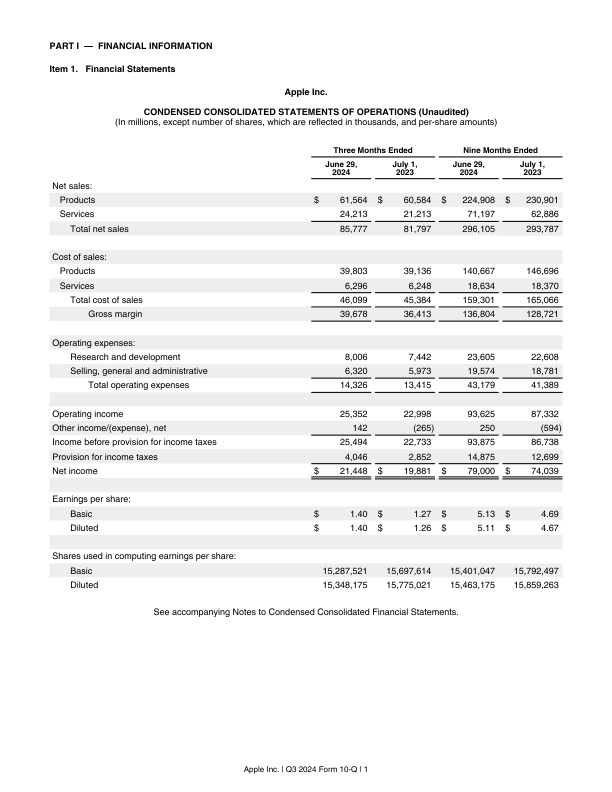

In [82]:
from IPython.display import Image as IPImage
from IPython.display import display

display(IPImage(data=base64.b64decode(page_image)))

In [83]:
query = "what is latest number for Net sales?"
answer, total_tokens_used = reader.run_multimodal_query(query, page_image)

In [84]:
print (answer)
print (f'Total Tokens used to generate this answer is {total_tokens_used}')

The latest number for total net sales for the three months ended June 29, 2024, is $85,777 million.
Total Tokens used to generate this answer is 900


In [85]:
# Asking another fact based query
query="what is latest value for Net Income?"
matching_chunk_index = reader.vector_search(query)
print (matching_chunk_index)
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index)
print (page_number)
page_image = reader.pdf_page_to_base64(page_number)
reader.run_multimodal_query(query, page_image)

20
3


('The latest net income value for the three months ended June 29, 2024, is $21,448 million.',
 898)

In [86]:
# Asking another fact based query
query="what is the revenue earned from products in 2024?"
matching_chunk_index = reader.vector_search(query)
print (matching_chunk_index)
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index)
print (page_number)
page_image = reader.pdf_page_to_base64(page_number)
reader.run_multimodal_query(query, page_image)

67
8


('The revenue earned from products in 2024 for the nine months ended June 29, 2024, is as follows (in millions):\n\n- iPhone: $115,964\n- Mac: $20,840\n- iPad: $19,744\n- Wearables, Home and Accessories: $27,963\n\nTotal product revenue: $184,511 million.',
 955)

In [87]:
# Asking another fact based query
query="what is the net sales  from products in 2024?"
matching_chunk_index = reader.vector_search(query)
print (matching_chunk_index)
page_number = reader.get_pagenum_for_chunk(chunks,matching_chunk_index)
print (page_number)
page_image = reader.pdf_page_to_base64(page_number)
reader.run_multimodal_query(query, page_image)

15
3


('The net sales from products for the nine months ended June 29, 2024, is $224,908 million.',
 810)